In [33]:
import os
import json
import time
import argparse
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import torch

from cbf import CBFModel
from neural_clbf.controllers.simple_neural_cbf_controller import SimpleNeuralCBFController
from neural_clbf.systems.simple3d import Simple3DRobot
from vis_utils import *
from navhelper import *

from scipy.spatial import cKDTree
import networkx as nx

import pandas as pd
import k3d
import json


In [72]:
'''

python traj_run_one.py 
  --goal_csv  /scratch/rhm4nj/cral/cral-ginn/ginn/goal_csvs/room_0_start_goal.csv
  --index 16 
  --params_json params.json
  --out_dir traj_outputs

----

  python traj_run_one.py 
  --goal_csv    /scratch/rhm4nj/cral/cral-ginn/ginn/goal_csvs/office_3_start_goal.csv
  --index 16 
  --params_json params.json
  --out_dir traj_outputs

'''

####### CHANGED BY CMD LINE ARGS ###############
# p = argparse.ArgumentParser()
# p.add_argument('--goal_csv',    required=True,
#                 help="CSV of start_x,…,goal_z")
# p.add_argument('--index',       type=int, required=True,
#                 help="which row in that CSV to run")
# p.add_argument('--params_json', required=True,
#                 help="path to JSON of hyper-parameters")
# p.add_argument('--out_dir',     required=True,
#                 help="where to write traj_<index>.json")
# args = p.parse_args()
# params_json = args.params_json
# goal_csv = args.goal_csv
# index = args.index
# out_dir = args.out_dir

#########

# python -m nbconvert --to script traj_run_one.ipynb

goal_csv = "/scratch/rhm4nj/cral/cral-ginn/ginn/goal_csvs/office_3_start_goal.csv"
index = 5
params_json = "params.json"
out_dir = "traj_outputs"

####### CHANGED BY CMD LINE ARGS ###############

with open(params_json) as f:
    cfg = json.load(f)

env_name = "_".join(goal_csv.split("/")[-1].split("_")[:2])
cfg['waypoints'] = False
cfg["obstacle"] = False and cfg['waypoints']
cfg["still_obst_limit"] = 25
cfg["display"] = True

cfg["obstacle_idx"] = 8
cfg['data_directory'] = f"/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/{env_name}_objects"
cfg['mask_dist'] = 0.4
cfg['alpha'] =  6
cfg['step_size'] = 0.05
cfg['cbf_lambda'] = -1.2
cfg['still_limit'] = 500
cfg["lookahead_factor"] = 10

# ─── Convert those list fields back into tensors ───
cfg['all_scale_factors']       = torch.tensor(cfg['all_scale_factors'],       dtype=torch.float32)
cfg['all_center_translations'] = torch.tensor(cfg['all_center_translations'], dtype=torch.float32)
cfg['all_bounds']              = torch.tensor(cfg['all_bounds'],              dtype=torch.float32)
device = 'cuda:0'
model, z_div = CBFModel.create_model(
    config_paths            = cfg['config_paths'],
    sub_model_paths         = cfg['sub_model_paths'],
    alpha                   = cfg['alpha'],
    device                  = device,
    all_scale_factors       = cfg['all_scale_factors'].to(device),
    all_center_translations = cfg['all_center_translations'].to(device),
    all_bounds              = cfg['all_bounds'].to(device),
)
model = model.to(device)

model.mask_dist   = cfg['mask_dist']
model.alpha       = cfg['alpha']
model.do_mask     = True
model.upper_bound = cfg.get('upper_bound', 5)
model.scale       = cfg.get('scale', 1)

model.reset_submodels()

# 2) pick start/goal
df  = pd.read_csv(goal_csv)
row = df.iloc[index]
start = row[['start_x','start_y','start_z']].to_numpy()
goal  = row[['goal_x','goal_y','goal_z']].to_numpy()

print(cfg['data_directory'])
print([(i, c.split("/")[-2]) for i,c in  enumerate(cfg['config_paths'])])

/scratch/rhm4nj/cral/cral-ginn/ginn/myvis/data_gen/replica/office_3_objects
[(0, '0_wall'), (1, '1_table'), (2, '2_table'), (3, '3_chair'), (4, '4_tv-stand'), (5, '5_chair'), (6, '6_chair'), (7, '7_undefined'), (8, '8_chair'), (9, '9_ceiling'), (10, '10_floor')]


In [50]:
threshold = min_pcd_dist = 0.4
max_waypoints = 6
env_name = "room_0"
env_name = "_".join(cfg['data_directory'].split("/")[-1].split("_")[:2])
points_name = "original.npy"
points = {}

for dirname in sorted(os.listdir(cfg["data_directory"])):
    points_path = os.path.join(cfg["data_directory"], dirname, points_name)
    points[dirname] = np.load(points_path)
pm = PointsManager({n: p for n, p in points.items() if "ceiling" not in n})

if cfg['waypoints']:
    point_samples = get_prm_samples(
            pm, start, goal,
            num_samples=2500,
            collision_threshold=min_pcd_dist,
            z_range=0.5
    )

    waypoints = None
    threshold = 0.05
    while waypoints is None:
        print("Attempt")
        start_t = torch.tensor(start, dtype=torch.float32)
        goal_t = torch.tensor(goal, dtype=torch.float32)
        waypoints = generate_safe_path(
            pm, start_t, goal_t,
            num_samples=2000,
            max_waypoints=max_waypoints,
            threshold=threshold
        )

    print("waypoints", waypoints.shape)
    waypoints = waypoints.float().to(device)

In [ ]:
########################### PLOTTING ###########################

def downsample_point_cloud_random(point_cloud, num_points):
    if point_cloud.shape[0] <= num_points:
        return point_cloud  # Already small enough
    indices = np.random.choice(point_cloud.shape[0], num_points, replace=False)
    return point_cloud[indices]

new_plot = k3d.plot(camera_auto_fit=False)
point_size = 0.05
line_width = 0.025
pm = PointsManager({n: p for n, p in points.items() if "9_ceiling" not in n})
point_cloud = pm.get_all_points()
small_pcd = downsample_point_cloud_random(point_cloud, min(point_cloud.shape[0], 200000))
new_plot += k3d.points(positions=small_pcd.astype(np.float32), point_size=0.01)

point_on_plane = np.mean(point_cloud, axis=0)
point_on_plane[2] = -3.14 # room_0
normal = np.array([0, 0, 1])
my_plane = InteractivePlane(point_on_plane, normal, new_plot, size=10, color=0xff0000) # color as mesh  0xff0000

model.reset_submodels()
new_plot.display()
new_plot.camera = [3.467074093287802, 1.5136175779222774, 5.52609292970741, 3.7041622184074083, 1.3540040518051255, -0.33680367107978, -0.016295361574148355, 0.9994867344945908, 0.02758131179815139]

model.reset_submodels()
hide_top = [i for i in range(len(model.configs)) if i != 9]
model.set_submodels(hide_top)
model.bounds = torch.stack(model.bounds,      dim=0).to(model.device)  # shape (M,2,3)
model.scale_factors = torch.stack(model.scale_factors,      dim=0).to(model.device)
model.centers_for_translations = torch.stack(model.centers_for_translations, dim=0).to(model.device)
CBFModel.update_plot(model, z_div, new_plot, mc_resolution=80, w=25)

# if cfg['waypoints']:
#     new_plot += k3d.line(waypoints.detach().cpu().numpy(), color=0x301934, width=line_width)
#     new_plot += k3d.points(waypoints.detach().cpu().numpy(), color=0x301934, point_size=point_size)

#     # new_plot += k3d.points(point_samples, color=0xf000ff, point_size=point_size / 2)

# start - aqua
point = k3d.points(positions=[states_over_time[-750]], point_size=point_size, color=0x00FFFF)
new_plot += point

# goal - green
goal_point = k3d.points(positions=goal, point_size=point_size, color=0x00FF00)
new_plot += goal_point

# new_plot.camera

new_plot += k3d.line(states_over_time[:-750], color=0x0fff00, width=line_width)

########################### PLOTTING ###########################



FloatSlider(value=-3.14, description='Z Height', max=10.0, min=-10.0)

Output()

TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the int 0.

TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the int 0.

TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the int 0.

TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the int 0.

TraitError: The 'point_size' trait of a Points instance expected a float or a dict, not the int 0.

In [52]:
# model.reset_submodels()

dyn = Simple3DRobot(nominal_params={}, dt=cfg['step_size'], scenarios=[{}], device=device)
ctrl = SimpleNeuralCBFController(
    dynamics_model         = dyn,
    scenarios              = [{}],
    V_nn                   = model,
    cbf_lambda             = cfg['cbf_lambda'],
    cbf_relaxation_penalty = cfg.get('cbf_relaxation_penalty', 5),
    z                      = z_div.unsqueeze(0),
    device                 = device,
    agent_rad              = 0,
    xy_only                = False
)

if cfg['waypoints']:
    waypoints = waypoints.float().to(device)

point.positions = start
wp_idx = 0

ctrl.set_V_nn(model)
still = 0
still_obst = 0
wp_thresh = cfg['threshold'] * 3/4
prev_model_n = 0
print("STARTING with device", device, start, goal)
total_it_time = 0
start_time = time.time()

obst_thresh = 0.01

# prepare state & goal
states = torch.tensor(start[None, :], dtype=torch.float32).to(device)
goal_states = torch.tensor(goal[None, :], dtype=torch.float32).to(device)
zs = torch.full((1,1), z_div.item(), device=device)

inactivation_reasons = {}
durations = {}
states_over_time = []
values_over_time = []
lie_g_over_time = []
lie_f_over_time = []
urefs_over_time = []
u_over_time = []
lips = []

for it in tqdm(range(cfg['max_iterations'])):
    if cfg["waypoints"]:
        if torch.norm(states - waypoints[wp_idx], dim=1) < wp_thresh:
            wp_idx += 1
            print("Moved to WP", wp_idx)
            # new_plot += k3d.points(positions=[waypoints[wp_idx].detach().cpu().numpy()], point_size=point_size, color=0xFFFFFF)
    
    if (not cfg["waypoints"] or wp_idx >= waypoints.shape[0]) and torch.norm(states - goal_states, dim=1) < cfg['threshold']:
        inactivation_reasons[0] = "goal_reached"
        durations[0] = it
        print("REACHED GOAL!!!")
        break

    it_start_time = time.time()
    model_indices = model.get_submodel_in_rad(states, cfg['step_size'] * cfg["lookahead_factor"])
    if cfg["obstacle"]: 
        model_indices += [cfg["obstacle_idx"]]

    if len(model_indices) != 0:
        model.set_submodels(model_indices)
    else:
        model.set_submodels([0])
        print("Empty")

    if len(model_indices) != prev_model_n:
        print("Switched to models", len(model_indices), model_indices)

        if cfg["display"]:
            model.bounds = torch.stack(model.bounds,      dim=0).to(model.device)  # shape (M,2,3)
            model.scale_factors = torch.stack(model.scale_factors,      dim=0).to(model.device)
            model.centers_for_translations = torch.stack(model.centers_for_translations, dim=0).to(model.device)
            CBFModel.update_plot(model, z_div, new_plot, mc_resolution=80, w=25)

    prev_model_n = len(model_indices)
    ctrl.set_V_nn(model)

    # 2) evaluate V
    V = model(states, zs)
    values_over_time.append(V.clone().detach().cpu().item())

    # 3) check unsafe
    if V[0] < 0:
        inactivation_reasons[0] = "unsafe_region"
        durations[0] = it
        print("FAILED!!!")
        break

    if cfg["obstacle"] and ((still_obst >= cfg["still_obst_limit"] and model.get_dist_to_submodel(len(model.bounds)-1, states[0]) < obst_thresh) or it == 0):
        tmp_wp_idx = wp_idx
        if it == 0:
            tmp_wp_idx += 1
        
        # print(tmp_wp_idx, len(waypoints))
        while tmp_wp_idx < len(waypoints):
            # assume model to move is the last!
            model.move_model(len(model.bounds)-1, waypoints[tmp_wp_idx])
            V = model(states, zs)
            if V[0] < 0:
                tmp_wp_idx += 1
            else:
                break
        
        print("Blocking", tmp_wp_idx)
        still_obst = 0

        if tmp_wp_idx >= len(waypoints):
            print("Fininshed Blocking!")
            model.move_model(len(model.bounds)-1, waypoints[0])
    else:
        still_obst += 1

    # print(still_obst, cfg["obstacle"])
    
    # 4) compute u_ref
    if cfg["waypoints"]:
        u_ref = torch.nn.functional.normalize(waypoints[wp_idx] - states, dim=1).to(device) * cfg['step_size']
    else:
        u_ref = torch.nn.functional.normalize(goal_states - states, dim=1).to(device) * cfg['step_size']

    # 5) lip term
    lip = torch.zeros_like(V)
    lip = model.compute_softmax_lipschitz(states, zs)
    lip = lip.clamp(max=abs(cfg['cbf_lambda'] - cfg['min_cbf_lambda'])) * cfg['step_size']
    ctrl.set_lipshitz(lip)
    lips.append(lip.detach().cpu().item())

    # 6) get control
    u = ctrl.get_optimal_control(states, u_ref=u_ref, requires_grad=False)
    u_over_time.append(u.detach().cpu().numpy()[0].tolist())
    urefs_over_time.append(u_ref.detach().cpu().numpy()[0].tolist())

    total_it_time += (time.time() - it_start_time)

    # 7) step dynamics
    states = dyn.next_state(states, u).to(device)
    states_over_time.append(states.clone().detach().detach().cpu().numpy()[0].tolist())

    if len(states_over_time) > 1:
        prev = torch.as_tensor(states_over_time[-2])  # convert to tensor if needed
        curr = torch.as_tensor(states_over_time[-1])
        if torch.norm(prev - curr) < 1e-4:
            still += 1
            if still == 1:
                print("STOPPING...")
        else:
            still = 0
        
    if still > cfg['still_limit']:
        inactivation_reasons[0] = "stopped_moving"   # fixed spelling
        durations[0] = it
        print("STOPPED MOVING!!", durations[0])
        break

    point.positions = states.detach().cpu()

    # # 8) record Lie derivatives
    Lf_V, Lg_V = ctrl.V_lie_derivatives(states)
    lie_g_over_time.append(Lg_V.squeeze(1).detach().cpu().numpy().tolist())
    lie_f_over_time.append(Lf_V.squeeze(1).detach().cpu().numpy().tolist())

    lie_g_over_time.append(Lg_V.squeeze(1).detach().cpu().numpy())
    lie_f_over_time.append(Lf_V.squeeze(1).detach().cpu().numpy())

# if never deactivated, mark failure
if len(inactivation_reasons) == 0:
    inactivation_reasons[0] = "timeout"
    durations[0] = cfg['max_iterations']

# 6) assemble JSON
traj = {
    "trajectory_index": index,
    "reason": inactivation_reasons[0],
    "duration": durations[0],
    "avg_step_time": total_it_time / max(1, it),
    "total_time": time.time() - start_time,
    "steps": []
}
for t in range(durations[0]):
    traj["steps"].append({
        "state":   states_over_time[t],
        "value":   values_over_time[t],
        "lie_g":   lie_g_over_time[t],
        "lie_f":   lie_f_over_time[t],
        "u_ref":   urefs_over_time[t],
        "u":       u_over_time[t],
        "lip":     lips[t]
    })

new_plot += k3d.line(states_over_time, color=0x0fff00, width=line_width)

# 7) write it out
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"traj_{index:04d}.json")
with open(out_path, 'w') as fo:
    json.dump(traj, fo, indent=2, default=lambda o: o.tolist())
print(f"Wrote {out_path}")

new_plot += k3d.line(states_over_time, color=0x0fff00, width=line_width)

CREATED SIMPLE3D
{}
STARTING with device cuda:0 [-3.22774274 -1.59441578 -0.8       ] [ 1.619583  -0.2603473 -0.8      ]


  0%|          | 0/5000 [00:00<?, ?it/s]

Switched to models 4 [0, 1, 3, 10]


  4%|▍         | 203/5000 [00:19<05:59, 13.33it/s]

Switched to models 3 [0, 1, 10]


 10%|▉         | 481/5000 [00:32<03:34, 21.03it/s]

Switched to models 4 [0, 1, 8, 10]


 16%|█▌        | 792/5000 [00:54<05:39, 12.39it/s]

Switched to models 3 [0, 8, 10]


 23%|██▎       | 1161/5000 [01:11<02:56, 21.74it/s]

STOPPING...


 33%|███▎      | 1656/5000 [01:33<03:09, 17.63it/s]


STOPPED MOVING!! 1656
Wrote traj_outputs/traj_0005.json


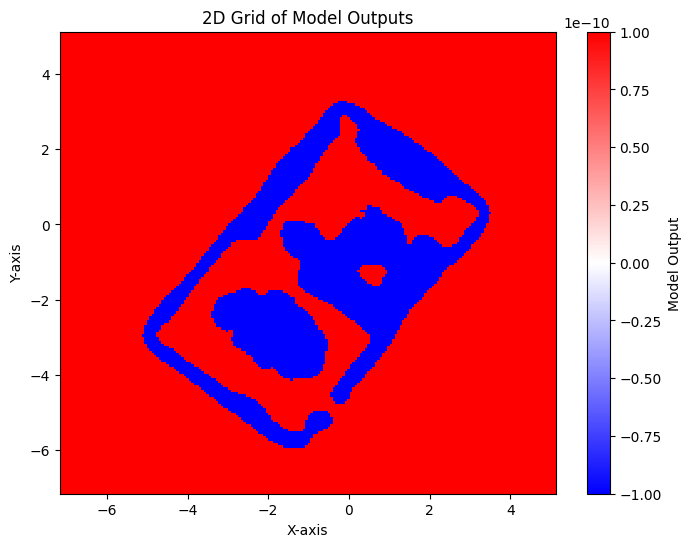

Z: -0.6821678


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

%matplotlib inline

def plot_2d_grid_with_model(x_range, y_range, steps, model, points=None, z_level=0, z_div=None, arrows=None):
    # Generate x and y linspace
    x_values = torch.linspace(*x_range, steps)
    y_values = torch.linspace(*y_range, steps)
    X, Y = torch.meshgrid(x_values, y_values, indexing="ij")
    
    # Flatten the grid for model input
    flattened_X = X.flatten()
    flattened_Y = Y.flatten()
    flattened_Z = torch.full_like(flattened_X, z_level)
    
    # Prepare inputs for the model
    xy_inputs = torch.stack([flattened_X, flattened_Y, flattened_Z], dim=1)
    z_inputs = torch.full((xy_inputs.shape[0], 1), z_div.item())

    output = model(xy_inputs, z_inputs)
    Z = output.view(steps, steps).detach().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    # norm = mcolors.TwoSlopeNorm(vmin=-1e-10, vcenter=0, vmax=1e-10)
    c = ax.pcolormesh(X.numpy(), Y.numpy(), Z, shading='auto', cmap='bwr', norm=norm)
    plt.colorbar(c, ax=ax, label='Model Output')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Grid of Model Outputs')

    # Plot individual points if provided
    if points:
        for point in points:
            print("Point V", point, model(torch.tensor([point]), z_div.unsqueeze(0)).cpu().tolist())
        points_x, points_y, points_z = zip(*points)  # Unpack the points into x and y coordinates
        ax.scatter(points_x, points_y, color='green', s=50, label='Points')

    # Plot the arrow if provided
    if arrows:
        for arrow in arrows:
            (x_start, y_start), (x_end, y_end), color = arrow
            ax.arrow(x_start, y_start, x_end - x_start, y_end - y_start, 
                    head_width=0.2, head_length=0.3, fc=color, ec=color, linewidth=2, label='Arrow')

    # Add legend if points or arrow are plotted
    if points or arrows:
        ax.legend()

    plt.savefig("cylinder_safety.png")
    plt.show()

# Example usage
# model.upper_bound = 15
width = 6

model.reset_submodels()
# model.mask_dists = 0.1
# model.alpha = 2

plot_2d_grid_with_model(
    x_range=(point.positions[0][0] - width, point.positions[0][1] + width),
    y_range=(point.positions[0][0] - width, point.positions[0][1] + width),
    steps=200,
    z_div = z_div,
    model=model,
    z_level=point.positions[0][2],
    # points=[point.positions],
    # points=[[1, 1.1,-1.1]],
    # arrows=[arrow_u, arrow_uref]
)

print("Z:", point.positions[0][2])
# Z: -0.6821678

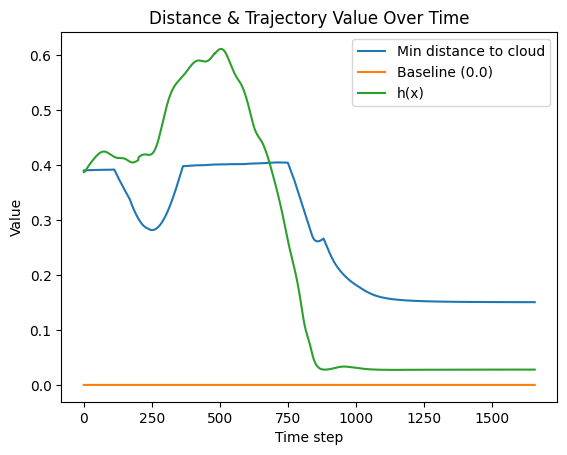

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# assume:
#   states_over_time: list of (x,y,z) points, length N
#   point_cloud:       np.ndarray of shape (M,3)
#   trajectory_values: list or array of length N

# 1) make your states into an (N,3) array
states_arr = np.asarray(states_over_time)
tree = cKDTree(point_cloud)
min_dists, _ = tree.query(states_arr, k=1)    # shape (N,)

values_arr = np.array(values_over_time)

# 3) constant baseline of 0.03 for each time step
baseline = np.full(values_arr.shape, 0.03)  # shape (N,)
baselinez = np.full(values_arr.shape, 0.0)  # shape (N,)

# 5) plot
plt.figure()
plt.plot(min_dists, label='Min distance to cloud')
# plt.plot(baseline,  label='Baseline (0.03)')
plt.plot(baselinez,  label='Baseline (0.0)')
plt.plot(values_over_time, label='h(x)')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Distance & Trajectory Value Over Time')
plt.legend(loc='upper right')
plt.show()
